In [104]:
from __future__ import annotations
import numpy as np 
from matplotlib import pyplot as plt
import itertools
from numba import jit, int32, float32
from numba.experimental import jitclass
import os

In [130]:

@jitclass([
    ('id', int32),
    ('x',float32),
    ('y',float32),
])
class Point:
    def __init__(self,id:int, x:float, y:float):
        self.id = id
        self.x = x
        self.y = y
    
@jit
def distance(p1:Point,p2:Point):
    return np.sqrt((p1.x-p2.x)**2 + (p1.y - p2.y)**2)

@jit
def calculate_path_length(path: list)->float:
    length = distance(path[0], path[-1]) # Uwzglednienie toru zamknietego
    for i in range(len(path) - 1):
        length += distance(path[i], path[i+1])
    return length

# @jit
def find_greedy_salesman_path(points: list)->list:
    path = []
    remaining_points = points.copy()
    first_point_index = np.random.randint(0, len(points) - 1)
    current_point = remaining_points.pop(first_point_index)
    path.append(current_point)
        
    while len(remaining_points) > 0:
        remaining_points.sort(key= lambda p: distance(current_point, p))
        current_point = remaining_points.pop(0)
        path.append(current_point)
    return path  

# @jit
def find_brutal_salesman_path(points: list)->list:
    assert(len(points) < 9)
    points = points.copy()
    paths = list(itertools.permutations(points, len(points)))
    paths.sort(key=lambda path : calculate_path_length(path), reverse=False)
    return paths.pop(0)

In [ ]:
points = [Point(1,1,2), Point(2,1,3), Point(3,1,4)]

# greedy_path
brute_path_lengths = []
greedy_path_lengths = []
random_path_lengths = []

np.random.seed(42069)

for i in range(1000):
    points = [Point(i, np.random.random(), np.random.random()) for i in range(7)]
    brute_path_lengths.append(calculate_path_length(find_brutal_salesman_path(points)))
    greedy_path_lengths.append(calculate_path_length(find_greedy_salesman_path(points)))
    random_path_lengths.append(calculate_path_length(points))
    

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(random_path_lengths, 50, label='random')
plt.hist(brute_path_lengths, 50, label='brute')
plt.hist(greedy_path_lengths, 50, label='greedy')

plt.legend()
plt.show()

# Genetyczne

In [106]:
# Before running compile algos.c -> run_algos (./Makefile.sh)
# Creates files: cities.txt, path_lengths.txt 
# * cities.txt - cities ordered in best found path
# * path_lengths.txt - 1st col: best path of every iteration, 2nd col: all time best
def gen_algo_run(num_cities, pop_size, mut_prob, cross_prob, num_iters):
    cmd = "./run_algos {0} {1} {2} {3} {4} > cities.txt".format(num_cities, pop_size, mut_prob, cross_prob, num_iters)
    os.system(cmd)
    shortest_path_history = np.loadtxt("path_lengths.txt")
    cities_in_best_order = np.loadtxt("cities.txt")
    return shortest_path_history.T, cities_in_best_order.T
def cities_to_points_list(cities):
    return [Point(i, cities[0, i], cities[1, i]) for i in range(cities[0].size)]
def points_list_to_xy(points):
    xret = np.empty(len(points))
    yret = np.empty(len(points))
    for i in range(len(points)):
        xret[i] = points[i].x
        yret[i] = points[i].y
    return xret, yret
    

In [ ]:
# (64, 1024, 8.0/1024, 0.2, 5000) ~ 30 sec
# (32, 10000, 8.0/10000, 0.2, 1000) ~ 2m30s
hist, cities = gen_algo_run(32, 10000, 8.0/10000, 0.2, 1000)

Genetic best length = 5.068885
Greedy best length = 5.004690647125244


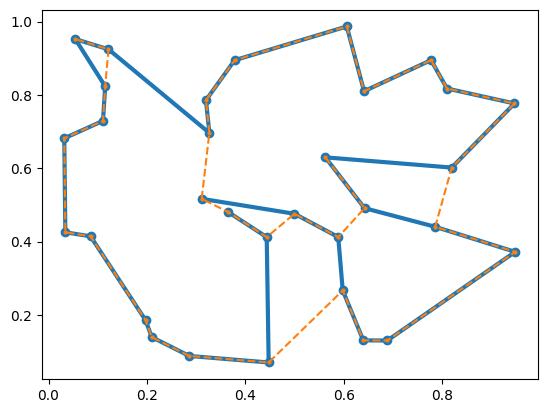

In [153]:

# Robimy kopie mias i je mieszamy, porownanie bedzie sprawiedliwe
cities_cpy = cities.copy()
np.random.shuffle(cities_cpy.T)

pts = cities_to_points_list(cities_cpy)
pts = find_greedy_salesman_path(pts)
greedy_len = calculate_path_length(pts)
greedy_x, greedy_y = points_list_to_xy(pts)

# Porownanie dlugosci
print(f"Genetic best length = {hist[1, -1]}")
print(f"Greedy best length = {greedy_len}")

# Plotowanie sciezek
plt.plot(cities[0], cities[1], '-o', lw=3.0, label='Genetic')
plt.plot(greedy_x, greedy_y, '--o', markersize=2.0, label='Greedy')

In [ ]:
plt.figure(figsize=(8, 6))
plt.grid()
plt.plot(hist[0], linewidth=0.1)
plt.plot(hist[1])

# Comparison of two methods

In [ ]:
num_cities = [8, 16, 32, 64, 128]
gen_lengths = []
greedy_lengths = []
for i in num_cities:
    h, c = gen_algo_run(i, 1024, 8.0/1024, 0.2, 1000)
    gen_lengths.append(h[1, -1])
    np.random.shuffle(c[0])
    np.random.shuffle(c[1])
    greedy_lengths.append(calculate_path_length(cities_to_points_list(c)))


In [ ]:
plt.plot(num_cities, gen_lengths, '.', label="Genetic")
plt.plot(num_cities, greedy_lengths, '.', label="Greedy")
plt.grid()
plt.xlabel("Number or cities")
plt.ylabel("Path length")
plt.legend()